In [105]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

from data_loading import load_isoform_and_paralog_y2h_data, load_m1h_activation_data

In [2]:
y2h = load_isoform_and_paralog_y2h_data()
m1h = load_m1h_activation_data()
y2h = y2h.loc[y2h['category'] == 'tf_isoform_ppis', :]

In [94]:
# what is the best metric for PPI partners whose loss is most associciated with change in
# activation?

def ppi_tf_gene(data, gene_name):
    tf = data.loc[(data['category'] == 'tf_isoform_ppis') &
                (data['ad_gene_symbol'] == gene_name),
                ['ad_clone_acc', 'db_gene_symbol', 'score']].copy()
    tf['score'] = tf['score'].map({'1': True,
                               '0': False,
                               'AA': np.nan,
                               'NC': np.nan})
    tf = tf.pivot(index='ad_clone_acc',
                  columns='db_gene_symbol',
                  values='score')
    return tf

# for each tf, for each partner, if differentially bound, absolute change in activation
data = []
for tf_gene in y2h['ad_gene_symbol'].unique():
    tf_ppi = ppi_tf_gene(y2h, tf_gene)
    tf_ppi = tf_ppi.loc[tf_ppi.any(axis=1), :]
    if tf_ppi.shape[0] < 2:
        continue
    tf_ppi = tf_ppi.loc[:, (tf_ppi == True).any(axis=0) & (tf_ppi == False).any(axis=0)]
    for partner in tf_ppi.columns:
        binds = tf_ppi.index[tf_ppi[partner] == True].values
        not_binds = tf_ppi.index[tf_ppi[partner] == False].values
        actv_diff = (m1h.loc[m1h['clone_acc'].isin(binds), ['M1H_rep1', 'M1H_rep2', 'M1H_rep3']].mean().mean()
                     - m1h.loc[m1h['clone_acc'].isin(not_binds), ['M1H_rep1', 'M1H_rep2', 'M1H_rep3']].mean().mean())
        data.append([tf_gene, partner, actv_diff])
df = pd.DataFrame(data=data, columns=['tf_gene', 'partner', 'activation_diff']).dropna()
df['num_points'] = df['partner'].map(df['partner'].value_counts())
df = df.sort_values(['num_points', 'partner', 'activation_diff'], ascending=False)

In [132]:
df.head(12)

,tf_gene,partner,activation_diff,num_points
335,MEIS2,ZNF417,1.332599,6
133,TCF4,ZNF417,0.803438,6
178,HMBOX1,ZNF417,0.228410,6
494,ZBTB44,ZNF417,-1.628360,6
298,ESRRG,ZNF417,-1.955542,6
446,ZSCAN18,ZNF417,-3.572874,6
455,E2F3,PRKAA2,7.433645,6
291,FOSB,PRKAA2,2.293175,6
96,TCF4,PRKAA2,1.774368,6
296,NFYA,PRKAA2,0.834103,6


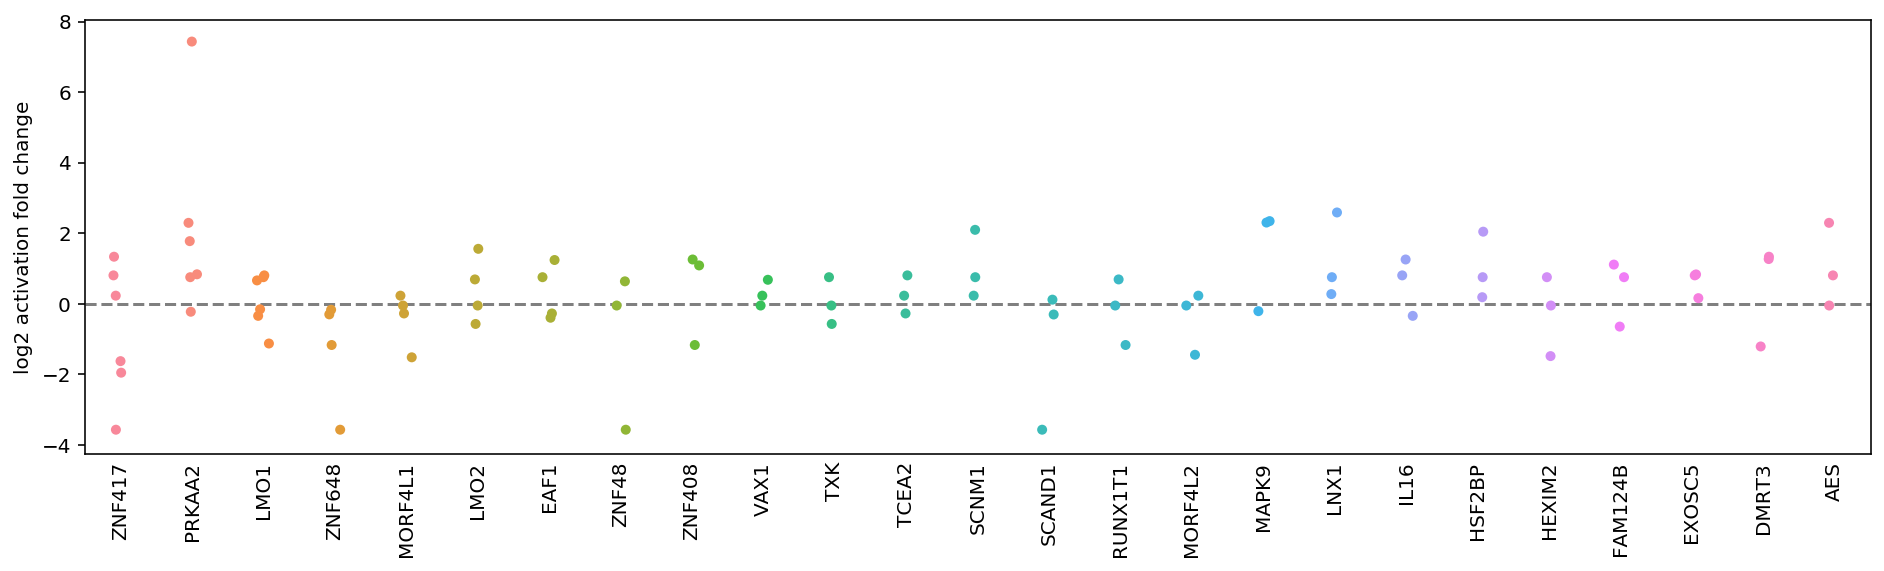

In [137]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(16, 4)
sns.stripplot(data=df.loc[df['num_points'] > 2, :],
              x='partner',
              y='activation_diff',
              ax=ax)
ax.axhline(0, linestyle='--', color='grey')
ax.set_xlabel('')
ax.set_ylabel('log2 activation fold change')
ax.tick_params(axis='x', rotation=90, length=0)
plt.savefig('../../figures/activation_change_per_ppi_partner.pdf',
            bbox_inches='tight')

In [133]:
df.loc[df['partner'] == 'MAPK9', :]

,tf_gene,partner,activation_diff,num_points
436,CREB5,MAPK9,2.342060,3
508,ATF2,MAPK9,2.301668,3
514,PPARG,MAPK9,-0.211298,3
